<h1>MUCKING AROUND WITH POTUS DATA AND MACHINE LEARNING</h1>

This is a typical example of a job interview challenge (usually given as a homework assignment to complete in a couple of hours): they will provide you with a training .csv, ask you to build some predicitve models and choose the best one; then to apply it to their test data .csv and send them the results, along with your code.
Here we try to predict presidential votes using a variety of machine learning algorithms, after some initial visualization and pre-processing.

<h2>IMPORT SOME LIBRARIES AND READ IN DATA</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
##check out tutorial here:
##http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/v0.1/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb
df = pd.read_csv('../train.csv')
df1 = df.drop('Winner', 1)
df['Win_bin'] = (df['Winner'] == 'Barack Obama') ##new column: logical wrt winner
df.head()

,Total population,Median age,% BachelorsDeg or higher,Unemployment rate,Per capita income,Total households,Average household size,% Owner occupied housing,% Renter occupied housing,% Vacant housing,Median home value,Population growth,House hold growth,Per capita income growth,Winner,Win_bin
0,9278,37.9,12.6,21.3,13992,3802,2.42,51.9,16.6,31.6,63959,-0.69,-0.49,0.71,Barack Obama,True
1,18594,36.3,9.7,14.3,14622,6764,2.55,63.7,16.2,20.1,74330,-0.13,0.03,0.85,Barack Obama,True
2,662628,37.9,27.9,12.1,23909,267862,2.41,57.0,28.8,14.2,112687,-0.09,0.00,0.55,Barack Obama,True
3,21292,38.9,14.1,15.7,16829,8547,2.47,63.5,17.1,19.4,73643,-0.59,-0.43,0.57,Barack Obama,True
4,13252,34.5,15.0,15.8,13012,5222,2.47,53.7,20.7,25.6,56642,-1.16,-1.03,0.69,Barack Obama,True


<h2>VISUALIZE THE DATA (1ST AND 2ND PRINCIPAL COMPONENTS)</h2>

(1213, 2)


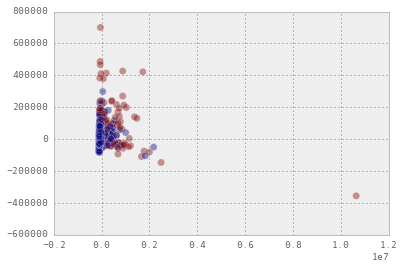

In [2]:
##using (parts of) andreas mueller's intro. to scikit-learn as a pseudo-template for analyzing 
##the POTUS data:
##https://github.com/amueller/sklearn_tutorial/blob/master/presentation.ipynb
from sklearn.decomposition import PCA #import principal component analysis
pca = PCA(n_components=2) #Instantiate the model & set parameters
pca.fit(df1); #Fit the model
df_pca = pca.transform(df1)#Apply the model. For embeddings / decompositions, this is transform.
print(df_pca.shape)
plt.scatter(df_pca[:, 0], df_pca[:, 1] , c = df['Win_bin'] , s = 50 , alpha=0.4);

In [3]:
##time to preprocess
from sklearn.preprocessing import scale
df2 = scale(df1) #this centers AND scales
#pd.DataFrame(df2)

<h2>SPLIT DATA INTO TRAINING AND TEST SETS</h2>

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, df['Winner'], test_size = 0.1, 
                                                    random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (1091, 14)
y_train shape: (1091,)
X_test shape: (122, 14)
y_test shape: (122,)


<h2>LET'S TRY A LINEAR SVM WITH K-FOLD CROSS VALIDATION</h2>

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    1.5s


Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'C': 0.10000000000000001}
0.84509624198


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.7s finished


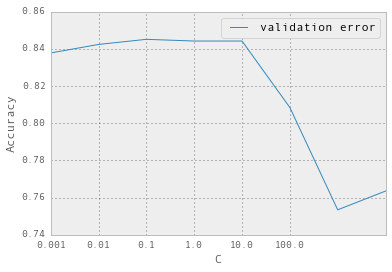

In [5]:
from sklearn.svm import LinearSVC
svm = LinearSVC() # Instantiate the model.
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
#also see here: http://scikit-learn.org/stable/auto_examples/grid_search_digits.html
svm = LinearSVC() # Instantiate the model
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search = GridSearchCV( svm , param_grid = tuned_parameters , cv = 10 ,verbose = 1 )
grid_search.fit(X_train, y_train);
print(grid_search.best_params_)
print(grid_search.best_score_)
##see here about the scoring:
##http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
##E.g. gives "accuracy" for SVMs:
##http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
plt.plot([c.mean_validation_score for c in grid_search.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');
#see this thread concerning mean_training_score:
#http://stackoverflow.com/questions/23389334/how-to-calculate-the-mean-training-score-using-gridsearchcv-in-scikit-learns

Wow! 84.5% accuracy is pretty good for a linear SVM.

<h2>NOW LET'S TRY A SVM WITH A GAUSSIAN KERNEL</h2>

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    1.4s


Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'C': 1.0}
0.843263061412


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.1s finished


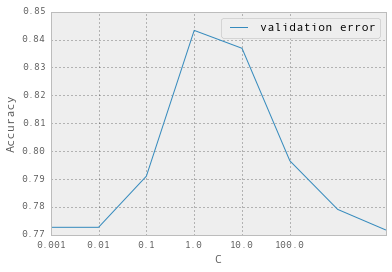

In [6]:
from sklearn.svm import SVC
svm1 = SVC(kernel='rbf')# Instantiate the model (SVM w/ Gaussian kernel)
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search1 = GridSearchCV( svm1 , param_grid = tuned_parameters , cv = 10 ,verbose = 1 )
grid_search1.fit(X_train, y_train);
print(grid_search1.best_params_)
print(grid_search1.best_score_)
plt.plot([c.mean_validation_score for c in grid_search1.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');


<h2>IT'S TIME TO TRY A RANDOM FOREST</h2>

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_estimators': 70}
0.843263061412


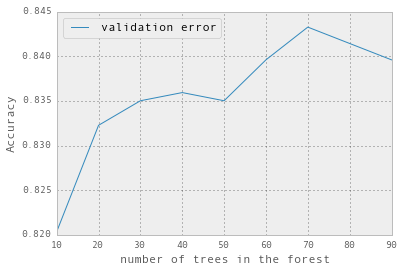

In [7]:
from sklearn.ensemble import RandomForestClassifier
#a random forest builds many randomized decision trees and averages their results.
rf = RandomForestClassifier() #Instantiate the model.
tuned_parameters = {'n_estimators':10*np.arange(1,10)}
grid_search2 = GridSearchCV( rf , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
grid_search2.fit(X_train, y_train);
print(grid_search2.best_params_)
print(grid_search2.best_score_)
plt.plot([c.mean_validation_score for c in grid_search2.grid_scores_], label="validation error")
plt.xticks(np.arange(9), tuned_parameters['n_estimators']); 
plt.xlabel("number of trees in the forest"); plt.ylabel("Accuracy");plt.legend(loc='best');


<h2>SEE HOW THE BEST MODELS FROM EACH CLASS PERFORM ON THE HOLDOUT SET</h2>

In [9]:
pred = grid_search.best_estimator_.predict(X_test)
pred1 = grid_search1.best_estimator_.predict(X_test)
pred2 = grid_search2.best_estimator_.predict(X_test)
###
acc = float(sum(np.equal(pred , y_test)))/len(y_test)
print('accuracy of best linear SVM = %s' % acc)
acc1 = float(sum(np.equal(pred1 , y_test)))/len(y_test)
print('accuracy of best Gaussian SVM = %s' % acc1)
acc2 = float(sum(np.equal(pred2 , y_test)))/len(y_test)
print('accuracy of best Random Forest = %s' % acc2)

accuracy of best linear SVM = 0.909836065574
accuracy of best Gaussian SVM = 0.885245901639
accuracy of best Random Forest = 0.868852459016


<h2> MAKE PREDICTIONS ON TEST SET </h2>

In [10]:
test_set = pd.read_csv('../test.csv')
test = scale(test_set) #this centers AND scales
print("test shape: %s" % repr(test.shape))
predictions = grid_search.best_estimator_.predict(test) #make predictions using the
#linear SVM that performed the best above
print(predictions)

test shape: (1901, 14)
['Barack Obama' 'Mitt Romney' 'Mitt Romney' ..., 'Mitt Romney'
 'Mitt Romney' 'Mitt Romney']


<h2>NEXT STEPS (STEPPING' UP REAL SOON! <-- PROBABLY TOMORROW) </h2>

Next up: check out scikit-learn's pipelines:
#http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html